In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import latent_plot as lp
from torch.autograd import Variable
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from data_loader import FundusDataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
csv_path = '/home/vip/sayan-mandal/datasets/obj_criteria/20200619-objective.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

FD = FundusDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor()]))

#random sampler
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(FD)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=valid_sampler)


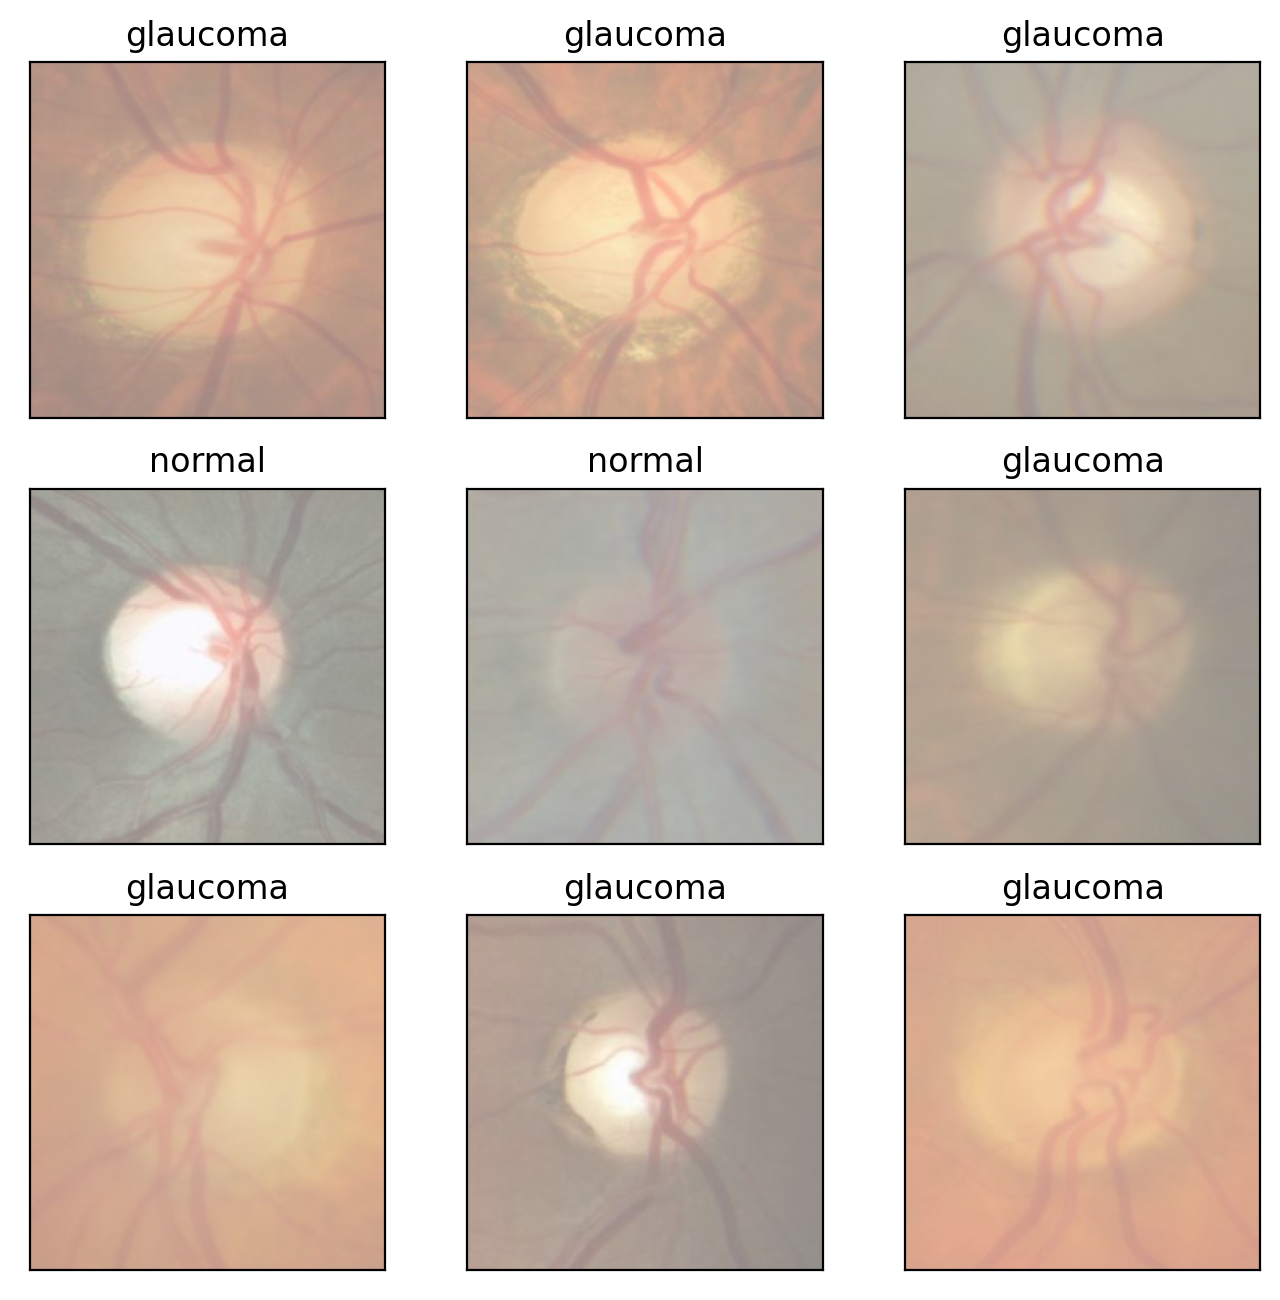

In [4]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['normal','glaucoma']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [5]:
#kl divergence loss
lossfunc = nn.BCEWithLogitsLoss()


def criterion(y, x, mu, logvar, lossfunc = lossfunc):
    # recontruction loss
    recon = lossfunc(y, x)
    # kl divergence between Q(z|x) ~ N(mu, sigma) and P(z) ~ N(0, I)
    kl_elem = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar) 
    kl = torch.sum(kl_elem).mul_(-0.5)
    return recon + kl

In [6]:
class VAE(nn.Module):
    def __init__(self, in_shape, n_latent):
        super().__init__()
        self.in_shape = in_shape
        self.n_latent = n_latent
        c,h,w = in_shape
        self.z_dim = h//2**2 # receptive field downsampled 2 times
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(c),
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # 32, 16, 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32, 8, 8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.z_mean = nn.Linear(64 * self.z_dim**2, n_latent)
        self.z_var = nn.Linear(64 * self.z_dim**2, n_latent)
        self.z_develop = nn.Linear(n_latent, 64 * self.z_dim**2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1),
            transforms.CenterCrop(224),
            nn.Sigmoid()
        )

    def sample_z(self, mean, logvar):
        stddev = torch.exp(0.5 * logvar).cuda()
        noise = Variable(torch.randn(stddev.size())).cuda()
        return (noise * stddev) + mean

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.z_mean(x)
        var = self.z_var(x)
        return mean, var

    def decode(self, z):
        out = self.z_develop(z)
        out = out.view(z.size(0), 64, self.z_dim, self.z_dim)
        out = self.decoder(out)
        return out

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.sample_z(mean, logvar)
        out = self.decode(z)
        return out, mean, logvar


#Instantiate the model
model = VAE((3,224,224),2).cuda()
print(model)

VAE(
  (encoder): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
  )
  (z_mean): Linear(in_features=200704, out_features=2, bias=True)
  (z_var): Linear(in_features=200704, out_features=2, bias=True)
  (z_develop): Linear(in_features=2, out_features=200704, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), paddin

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
ep,lss = [],[]
for e in range(1, epochs+1):
    print('Start training.')
    print('Epoch = ' + str(e))
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data).cuda()
        optimizer.zero_grad()
        y, mu, sig = model(data) # y = reconstructed image
        loss = criterion(y, data, mu, sig)
        loss.backward()
        optimizer.step()
        ep += [e]
        lss += [loss.cpu()]
    print(e, loss)

Start training.
Epoch = 1
1 tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
Start training.
Epoch = 2


KeyboardInterrupt: 

In [8]:
y.shape

torch.Size([64, 3, 225, 225])

In [9]:
data.shape

torch.Size([64, 3, 224, 224])